# Qcodes example with Alazar ATS 9360

In [3]:
# import all necessary things
%matplotlib nbagg

import qcodes as qc
import qcodes.instrument.parameter as parameter
import qcodes.instrument_drivers.AlazarTech.ATS9360 as ATSdriver
import qcodes.instrument_drivers.AlazarTech.ATS_acquisition_controllers as ats_contr

First lets list all the Alazar boards connected to this machine. In most cases this will probably only be a single one

In [4]:
ATSdriver.AlazarTech_ATS.find_boards()

[{'system_id': 1,
  'board_id': 1,
  'board_kind': 'ATS9360',
  'max_samples': 4294967294,
  'bits_per_sample': 12}]

In [5]:
ats_inst = ATSdriver.AlazarTech_ATS9360(name='Alazar1')
# Print all information about this Alazar card
ats_inst.get_idn()

{'firmware': None,
 'model': 'ATS9360',
 'max_samples': 4294967294,
 'bits_per_sample': 12,
 'serial': '970396',
 'vendor': 'AlazarTech',
 'CPLD_version': '25.16',
 'driver_version': '6.1.2',
 'SDK_version': '6.1.2',
 'latest_cal_date': '25-01-17',
 'memory_size': '4294967294',
 'asopc_type': '1779729248',
 'pcie_link_speed': '0.5GB/s',
 'pcie_link_width': '8'}

The Alazar is unusual compared to other instruments as it works together with an acquisition controller. The acquisition controller takes care of post processing and the driver takes care of the communication with the card. At the moment QCoDeS only ships with some very basic acquisition controllers. Here we use a controller that allows us to perform a demodulation of the signal acquired

In [6]:
# Instantiate an acquisition controller (In this case we are doing a simple DFT) and 
# provide the name of the name of the alazar card that this controller should control
acquisition_controller = ats_contr.Demodulation_AcquisitionController(name='acquisition_controller', 
                                                                      demodulation_frequency=10e6, 
                                                                      alazar_name='Alazar1')

The parameters on the Alazar card are set in a slightly unusual way. As communicating with the card is slow and multiple parameters needs to be set with the same command we use a context manager that takes care of syncing all the paramters to the card after we set them.

In [7]:
with ats_inst.syncing():
    ats_inst.clock_source('INTERNAL_CLOCK')
    ats_inst.sample_rate(1_000_000_000)
    ats_inst.clock_edge('CLOCK_EDGE_RISING')
    ats_inst.decimation(1)
    ats_inst.coupling1('DC')
    ats_inst.coupling2('DC')
    ats_inst.channel_range1(.4)
    ats_inst.channel_range2(.4)
    ats_inst.impedance1(50)
    ats_inst.impedance2(50)
    ats_inst.trigger_operation('TRIG_ENGINE_OP_J')
    ats_inst.trigger_engine1('TRIG_ENGINE_J')
    ats_inst.trigger_source1('EXTERNAL')
    ats_inst.trigger_slope1('TRIG_SLOPE_POSITIVE')
    ats_inst.trigger_level1(160)
    ats_inst.trigger_engine2('TRIG_ENGINE_K')
    ats_inst.trigger_source2('DISABLE')
    ats_inst.trigger_slope2('TRIG_SLOPE_POSITIVE')
    ats_inst.trigger_level2(128)
    ats_inst.external_trigger_coupling('DC')
    ats_inst.external_trigger_range('ETR_2V5')
    ats_inst.trigger_delay(0)
    ats_inst.timeout_ticks(0)
    ats_inst.aux_io_mode('AUX_IN_AUXILIARY') # AUX_IN_TRIGGER_ENABLE for seq mode on
    ats_inst.aux_io_param('NONE') # TRIG_SLOPE_POSITIVE for seq mode on

This command is specific to this acquisition controller. The kwargs provided here are being forwarded to instrument acquire function
This way, it becomes easy to change acquisition specific settings from the ipython notebook

In [8]:
acquisition_controller.update_acquisitionkwargs(#mode='NPT',
                 samples_per_record=1024,
                 records_per_buffer=70,
                 buffers_per_acquisition=1,
                 #channel_selection='AB',
                 #transfer_offset=0,
                 #external_startcapture='ENABLED',
                 #enable_record_headers='DISABLED',
                 #alloc_buffers='DISABLED',
                 #fifo_only_streaming='DISABLED',
                 #interleave_samples='DISABLED',
                 #get_processed_data='DISABLED',
                 allocated_buffers=1,
                 #buffer_timeout=1000
)

Getting the value of the parameter `acquisition` of the instrument `acquisition_controller` performes the entire acquisition protocol. This again depends on the specific implementation of the acquisition controller

In [9]:
acquisition_controller.acquisition()

4.503555182174678

In [10]:
# make a snapshot of the 'ats_inst' instrument
ats_inst.snapshot()

{'functions': {},
 'submodules': {},
 '__class__': 'qcodes.instrument_drivers.AlazarTech.ATS9360.AlazarTech_ATS9360',
 'parameters': {'IDN': {'value': None,
   'ts': None,
   'raw_value': None,
   '__class__': 'qcodes.instrument.parameter.Parameter',
   'full_name': 'Alazar1_IDN',
   'label': 'IDN',
   'name': 'IDN',
   'inter_delay': 0,
   'unit': '',
   'post_delay': 0,
   'vals': '<Anything>',
   'instrument': 'qcodes.instrument_drivers.AlazarTech.ATS9360.AlazarTech_ATS9360',
   'instrument_name': 'Alazar1'},
  'clock_source': {'value': 'INTERNAL_CLOCK',
   'ts': '2018-10-05 15:24:07',
   'raw_value': 1,
   '__class__': 'qcodes.instrument_drivers.AlazarTech.utils.TraceParameter',
   'full_name': 'Alazar1_clock_source',
   'label': 'Clock Source',
   'name': 'clock_source',
   'inter_delay': 0,
   'unit': '',
   'post_delay': 0,
   'val_mapping': {'INTERNAL_CLOCK': 1,
    'FAST_EXTERNAL_CLOCK': 2,
    'EXTERNAL_CLOCK_10MHz_REF': 7},
   'vals': "<Enum: {'INTERNAL_CLOCK', 'EXTERNAL_CLO

Finally show that this instrument also works within a loop


Started at 2018-10-05 15:24:10
DataSet:
   location = 'data/2018-10-05/#003_AlazarTest_15-24-10'
   <Type>   | <array_id>                         | <array.name> | <array.shape>
   Setpoint | dummy_set                          | dummy        | (50,)
   Measured | acquisition_controller_acquisition | acquisition  | (50,)
Finished at 2018-10-05 15:24:14


<IPython.core.display.Javascript object>


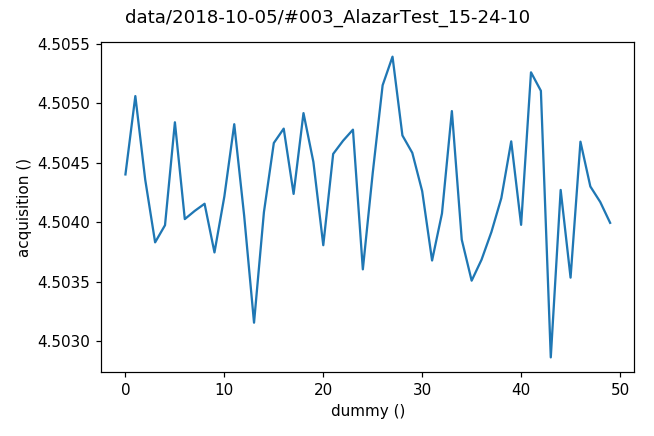

In [11]:
dummy = parameter.ManualParameter(name="dummy")
data = qc.Loop(dummy[0:50:1]).each(acquisition_controller.acquisition).run(name='AlazarTest')
qc.MatPlot(data.acquisition_controller_acquisition)